In [3]:
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [124]:
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
ticks = ["RAFGX","FUSVX", "AMDVX", "FSEVX", "JUSMX","IINCX","ODVIX","VREQX", "LIMKX", "LIHKX","LIPKX","LIVKX"]
end = date.today()
beg = end - relativedelta(years = 10)

In [125]:
data = pd.DataFrame(yf.download(ticks, start=beg, end=end)['Adj Close'])

[*********************100%***********************]  12 of 12 downloaded


In [126]:
#lets calc returns and cov matrix
rets = np.log(1+data.pct_change()).dropna()
mean_rets = rets.mean()*252
cov = rets.cov()*252
syms = len(ticks)


<Figure size 1440x720 with 0 Axes>

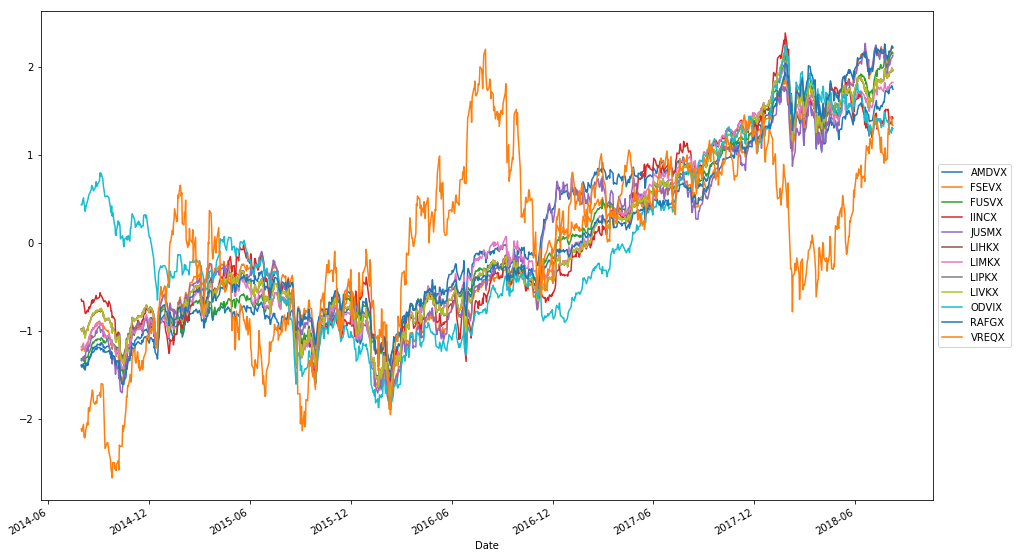

In [127]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataNA =data.dropna()
values = scaler.fit_transform(dataNA.values)
data_std = pd.DataFrame(values,index=dataNA.index, columns=dataNA.columns)

f = plt.figure(figsize = (20,10))
data_std.plot(figsize= (16,10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [128]:
##now we simulate the returns of the portfolio across random samples
prets = []
pvols = []

for trial in range(50000):
    weights = np.random.random(syms)
    weights /= np.sum(weights)
    prets.append(np.sum(mean_rets*weights))
    pvols.append(np.sqrt(np.dot(weights.T,
                                np.dot(cov,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

In [129]:
#function for computing portfolio returns, std, and shapre
def port_stats(weights):
    w = np.array(weights)
    r = np.sum(w*mean_rets)
    std = np.sqrt(np.dot(w.T,np.dot(cov,w)))
    sharpe = r/std
    return np.array([r,std,sharpe])

In [131]:
import scipy.optimize as sco
#boundaries
bnds = tuple((0,.3) for x in range(syms))
#constraints
cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})

#returns negative of sharpe b/c minimum of negative sharpe is the maximum of the sharpe ratio
def max_sharpe(weights):
    return -port_stats(weights)[2]

guess = syms*[1/syms]
sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)

#now lets find the min variance portfolio

def min_var(weights):
    return port_stats(weights)[1]

min_var_opt = sco.minimize(min_var, guess, method = 'SLSQP',constraints=cons, bounds=bnds)


In [146]:
#now lets create an efficient frontier for this dataset
frets = np.linspace(0.065, .12, 50)
fvols = []
for ret in frets:
    cons = ({'type':'eq', 'fun':lambda x: port_stats(x)[0]-ret},
            {'type':'eq','fun':lambda x: np.sum(x)-1})
    res = sco.minimize(min_var, guess, constraints = cons, bounds = bnds, method ='SLSQP')
    fvols.append(res['fun']) ## this is the actual vol
fvols = np.array(fvols)

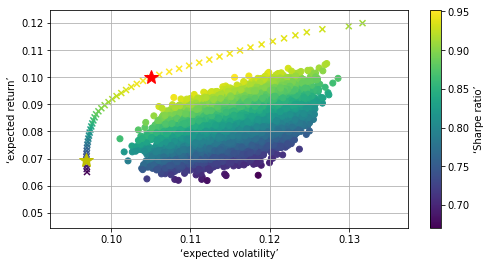

In [147]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(fvols, frets,
c=frets / fvols, marker='x')
# efficient frontier
plt.plot(port_stats(sharpe_opt['x'])[1], port_stats(sharpe_opt['x'])[0],
'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(port_stats(min_var_opt['x'])[1], port_stats(min_var_opt['x'])[0],
'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('‘expected volatility’')
plt.ylabel('‘expected return’')
plt.colorbar(label='‘Sharpe ratio’')

In [148]:
import scipy.interpolate as sci
##this code starts the interpolation at the minvar Portfolion
ind = np.argmin(fvols)
evols = fvols[ind:]
erets = frets[ind:]
tck = sci.splrep(evols, erets)


In [154]:
#define function
def f(x):
    return sci.splev(x,tck,der=0)
def df(x):
    return sci.splev(x,tck,der=1)

def CAPM_eq(p,rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2]-f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1,eq2,eq3

#solivng the CAPM equation
CAPM_opt = sco.fsolve(CAPM_eq,[.01,.85,.1])
CAPM_opt, np.round(CAPM_eq(CAPM_opt), 6)

C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(array([0.01      , 0.87276236, 0.10592863]),
 array([ 0.      ,  0.001655, -0.000178]))

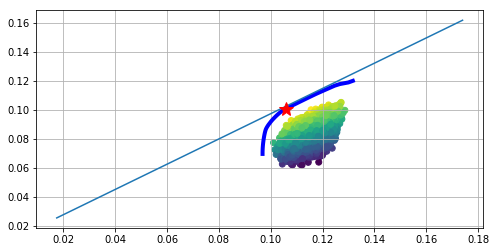

In [155]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'b', lw=4.0)
rang = np.linspace(.0175,.174)
plt.plot(rang, CAPM_opt[0] + CAPM_opt[1]*rang)
plt.plot(CAPM_opt[2], f(CAPM_opt[2]), 'r*', markersize=15.0)
plt.grid(True)

In [156]:
#lets mess around with a rolling optimization portfolio
monthly_bm_p = pd.DataFrame(yf.download('SPY', start=beg, end=end)['Adj Close'])
monthly_bm_p = monthly_bm_p.resample('BM').asfreq().ffill()
monthly_bm = np.log(1+monthly_bm_p.pct_change()).dropna()
monthly_bm.columns = ['SPY']
monthly_p = data.resample('BM').asfreq().ffill()
monthly = np.log(1+monthly_p.pct_change()).dropna()

[*********************100%***********************]  1 of 1 downloaded


In [157]:
###remove the last date unless today is last day of month
monthly.drop(monthly.tail(1).index,inplace=True)
monthly_bm.drop(monthly_bm.tail(1).index,inplace=True)

In [160]:
lookback = 12
def quadfit(train,trainBM,test,testBM,method):
    syms = train.shape[1]
    #boundaries
    bnds = tuple((0,.4) for x in range(syms))
    #constraints
    cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    guess = syms*[1/syms]
    
    #now lets find the min variance portfolio
    train_rets = train.mean()*12
    train_cov = train.cov()*12
    def port_stats(weights):
        w = np.array(weights)
        r = np.sum(w*train_rets)
        std = np.sqrt(np.dot(w.T,np.dot(train_cov,w)))
        sharpe = r/std
        return np.array([r,std,sharpe])
    def max_sharpe(weights):
        return -port_stats(weights)[2]
    def min_var(weights):
        return port_stats(weights)[1]
    if method.lower() == 'sharpe':
        opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)
    elif method.lower() == 'variance':
        opt = sco.minimize(min_var, guess, method = 'SLSQP',constraints=cons, bounds=bnds)
    else:
        return 'Please enter sharpe or variance'
    weights = opt['x']
    test_rets = np.dot(weights,test)
    test_rets_bm = testBM
    cols = ticks+['Port Returns']+['SPY Returns']
    arr = np.hstack([weights,np.array(test_rets),test_rets_bm]).reshape(1,14)
    result = pd.DataFrame(arr,columns=cols)
    result['date'] = test.name
    result.set_index(result['date'],inplace=True,drop=True)
    return result

In [161]:
minsim = lookback
maxsim = monthly.shape[0]

for sim in range(minsim,maxsim):
    train = monthly.iloc[sim-lookback:sim]
    train_bm = monthly_bm.iloc[sim-lookback:sim]
    test = monthly.iloc[sim]
    test_bm = monthly_bm.iloc[sim]
    result = quadfit(train,train_bm,test,test_bm,'sharpe')
    if sim == minsim:
        backtestWeights = result[ticks]
        backtestReturns = result[['Port Returns', 'SPY Returns']]
    else:
        backtestWeights = backtestWeights.append(result[ticks])
        backtestReturns = backtestReturns.append(result[['Port Returns', 'SPY Returns']])
    

In [172]:
from math import sqrt
#lets check out the portfolio stats and then graph the results
print('Mean Weights:\n', np.mean(backtestWeights),"Mean Returns:\n", np.mean(backtestReturns)*12, 
      'Std:\n', np.std(backtestReturns)*sqrt(12), 'Sharpe: ', sqrt(12)*np.mean(backtestReturns)/np.std(backtestReturns))

Mean Weights:
 RAFGX    2.387783e-01
FUSVX    5.899310e-03
AMDVX    4.280187e-02
FSEVX    3.681028e-02
JUSMX    1.313240e-02
IINCX    8.478612e-03
ODVIX    3.944731e-01
VREQX    8.007041e-03
LIMKX    5.014645e-17
LIHKX    8.093122e-02
LIPKX    6.832299e-02
LIVKX    1.023649e-01
dtype: float64 Mean Returns:
 Port Returns    0.095932
SPY Returns     0.126762
dtype: float64 Std:
 Port Returns    0.079694
SPY Returns     0.162375
dtype: float64 Sharpe:  Port Returns    1.203753
SPY Returns     0.780677
dtype: float64


In [174]:
minsim = lookback
maxsim = monthly.shape[0]

for sim in range(minsim,maxsim):
    train = monthly.iloc[sim-lookback:sim]
    train_bm = monthly_bm.iloc[sim-lookback:sim]
    test = monthly.iloc[sim]
    test_bm = monthly_bm.iloc[sim]
    result = quadfit(train,train_bm,test,test_bm,'variance')
    if sim == minsim:
        backtestWeights = result[ticks]
        backtestReturns = result[['Port Returns', 'SPY Returns']]
    else:
        backtestWeights = backtestWeights.append(result[ticks])
        backtestReturns = backtestReturns.append(result[['Port Returns', 'SPY Returns']])

In [175]:
print('Mean Weights:\n', np.mean(backtestWeights),"Mean Returns:\n", np.mean(backtestReturns)*12, 
      'Std:\n', sqrt(12)*np.std(backtestReturns), 'Sharpe: ', sqrt(12)*np.mean(backtestReturns)/np.std(backtestReturns))

Mean Weights:
 RAFGX    2.387783e-01
FUSVX    5.899310e-03
AMDVX    4.280187e-02
FSEVX    3.681028e-02
JUSMX    1.313240e-02
IINCX    8.478612e-03
ODVIX    3.944731e-01
VREQX    8.007041e-03
LIMKX    5.014645e-17
LIHKX    8.093122e-02
LIPKX    6.832299e-02
LIVKX    1.023649e-01
dtype: float64 Mean Returns:
 Port Returns    0.095932
SPY Returns     0.126762
dtype: float64 Std:
 Port Returns    0.079694
SPY Returns     0.162375
dtype: float64 Sharpe:  Port Returns    1.203753
SPY Returns     0.780677
dtype: float64


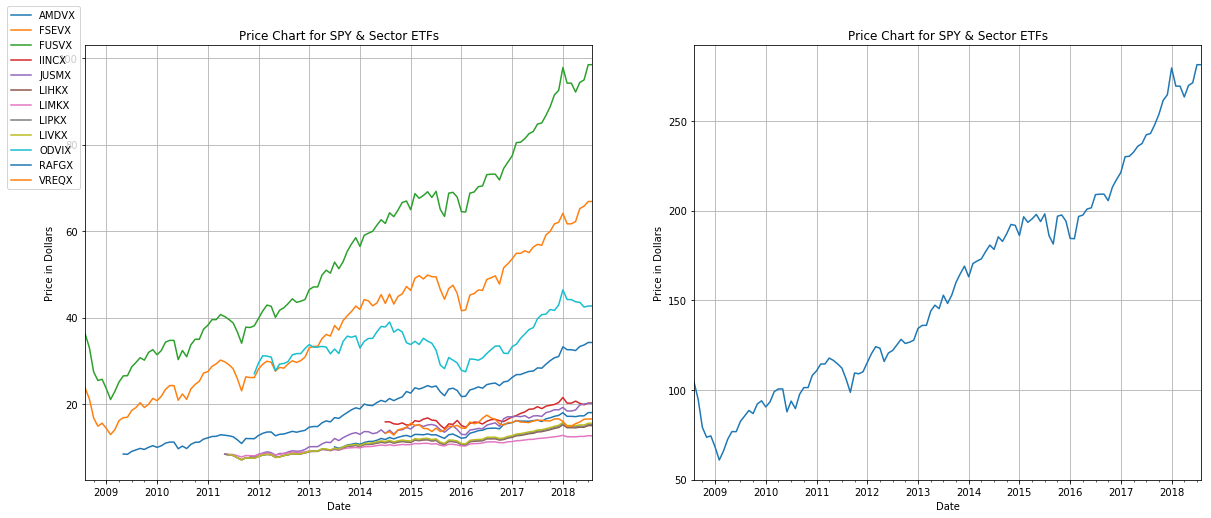

In [166]:
#min Variance portfolio seems to perform signifcantly better
combined_rets = monthly_p.join(monthly_bm_p, how='inner')
combined_rets.rename(columns={'Adj Close':'SPY'},inplace=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))
combined_rets.iloc[:,:-1].plot(ax=ax1,grid=True,xlim=(combined_rets.index[0],combined_rets.index[-1]),
                  title = 'Price Chart for SPY & Sector ETFs')
combined_rets.iloc[:,-1].plot(ax=ax2,grid=True,xlim=(combined_rets.index[0],combined_rets.index[-1]),
                  title = 'Price Chart for SPY & Sector ETFs')
ax1.set_ylabel('Price in Dollars')
ax2.set_ylabel('Price in Dollars')
ax1.legend(loc = 0, bbox_to_anchor = (0,1.1))

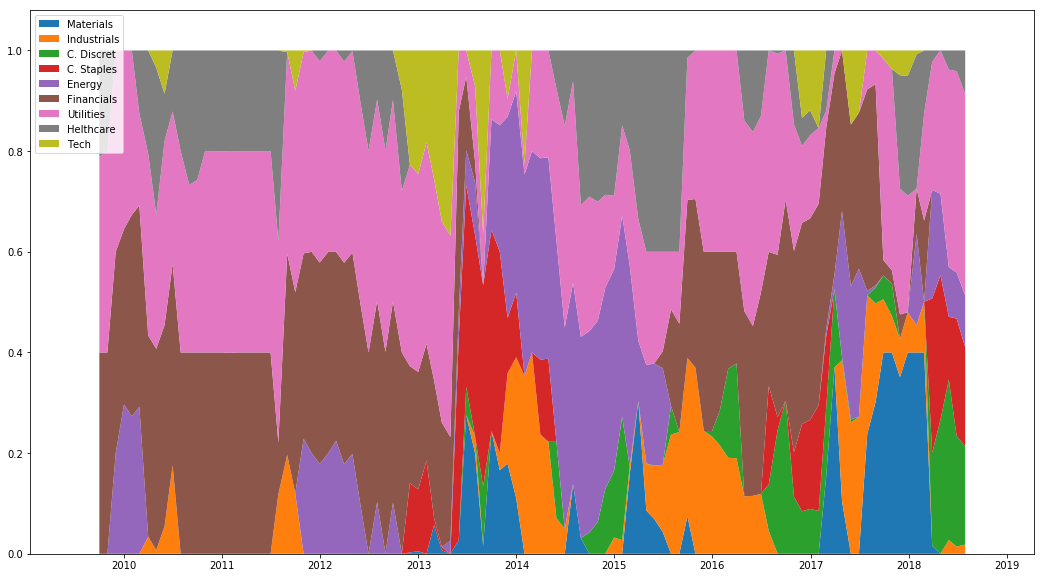

In [311]:
fig, ax = plt.subplots(figsize=(18,10))
percentages = backtestWeights.divide(backtestWeights.sum(axis=1), axis=0)
plt.stackplot(percentages.index, percentages["XLB"],  percentages["XLI"],  percentages["XLY"],
              percentages["XLP"],  percentages["XLE"],  percentages["XLF"],
              percentages["XLU"],  percentages["XLV"],  percentages["XLK"], 
              labels=['Materials','Industrials','C. Discret','C. Staples','Energy','Financials',
                     'Utilities','Helthcare','Tech'])
plt.legend(loc='upper left')
plt.margins(.08,.08)

In [167]:
from scipy.stats import norm
mu =backtestReturns.mean().values
sigma = backtestReturns.std().values
x1 = np.linspace(mu[0]-3*sigma[0],mu[0]+3*sigma[1])
x2 = np.linspace(mu[1]-3*sigma[1],mu[0]+3*sigma[1])
p1 = norm.pdf(x1, mu[0], sigma[0])
p2 = norm.pdf(x2, mu[1], sigma[1])

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


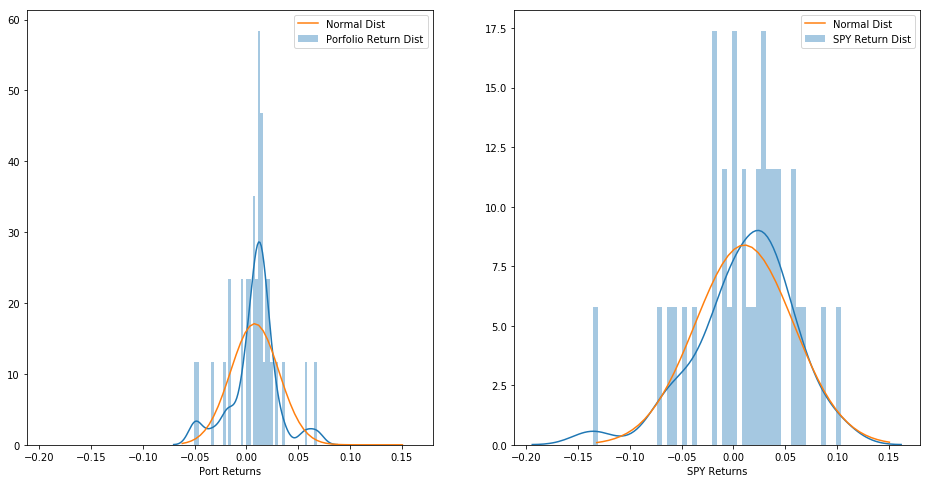

In [168]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8),sharex= True)
sns.distplot(backtestReturns['Port Returns'],bins= 50,ax=ax1,label="Porfolio Return Dist")
ax1.plot(x1,p1,label="Normal Dist")
ax1.legend(loc='upper right')
sns.distplot(backtestReturns['SPY Returns'],bins= 50,ax=ax2,label="SPY Return Dist")
ax2.plot(x2,p2,label="Normal Dist")
ax2.legend(loc='upper right')


In [169]:
import matplotlib.ticker as mtick 
def rollingSharpe(series,nper=12):
    return series.rolling(nper).mean().divide(series.rolling(nper).std(),axis=0)

def drawdown(df):
    return -(df.cumsum(axis=0).cummax(axis=0)-df.cumsum(axis=0))

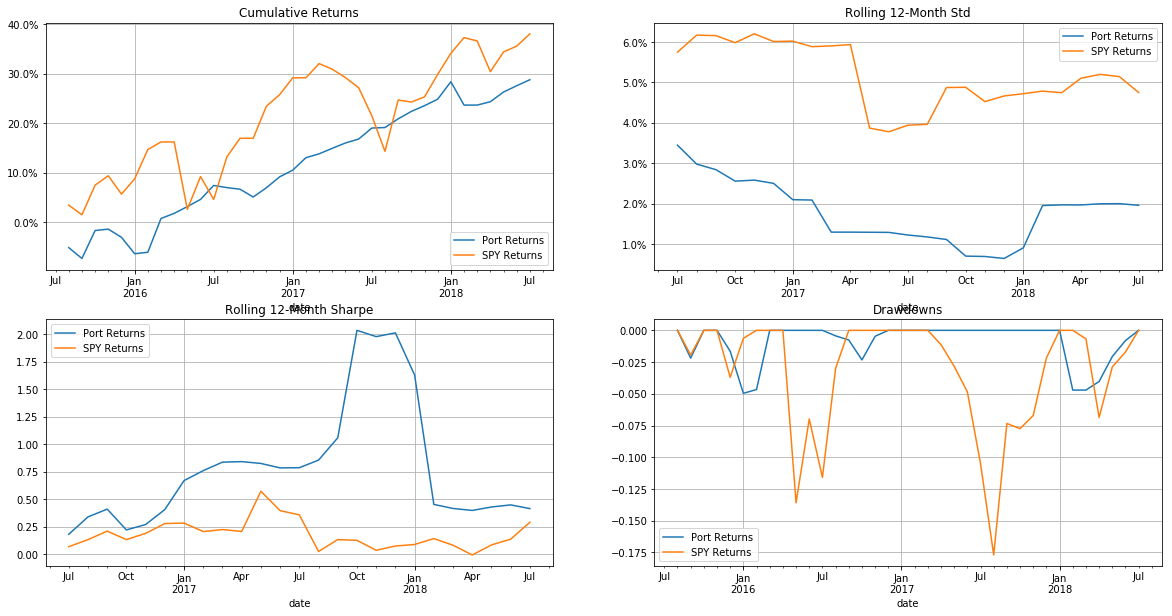

In [170]:
fig, ax = plt.subplots(2,2,figsize= (20,10))
(100*backtestReturns.cumsum(axis=0)).plot(ax=ax[0,0],title="Cumulative Returns")
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,0].grid(True)
ax[0,0].legend(loc = 'lower right')
(100*backtestReturns.rolling(12).std()).plot(ax=ax[0,1], title = 'Rolling 12-Month Std')
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[0,1].legend(loc ='upper right')
ax[0,1].grid(True)
rollingSharpe(backtestReturns,12).plot(title='Rolling 12-Month Sharpe',ax=ax[1,0],grid=True)
ax[1,0].legend(loc='upper left')
drawdown(backtestReturns).plot(title='Drawdowns',ax=ax[1,1],grid=True)

,Port Returns,Brk-B Returns
date,,
2009-09-30,0.000000,0.000000
2009-10-30,0.011488,0.012110
2009-11-30,0.000000,0.000000
2009-12-31,0.000000,0.020184
2010-01-29,0.044734,0.000000
2010-02-26,0.024214,0.000000
2010-03-31,0.000000,0.000000
2010-04-30,0.006682,0.053971
2010-05-31,0.006682,0.053971
